<a href="https://colab.research.google.com/github/ese-msc-2021/irp-ok121/blob/main/MasterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification workflow of gold mining ponds in Ghana

The purpose of this notebook is to demostrate how two developped customa packages - Tools and Unet can be used chronologocally to build, train and evaluate U-Net. It also shows how to apply the model on out-of sample data and to compute 3 graphs illustrating proposed applications in minor ferric iron monitoring:

- Cite comparison (e.g., with different environmental restoration strategies).

- The Seasonal cycle of mining activity levels and corresponding ferric fluctuation ( to indicate time of highest and lowest risk of AMD).

- Monitoring of temporal changes in pond type proportions vs MFI concentration.


# Importing packages and loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/irp-ok121')

In [ ]:
from Tools import preprocessor as pr
import imp
imp.reload(pr)


<module 'Tools.preprocessor' from '/content/drive/My Drive/irp-ok121/Tools/preprocessor.py'>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import scipy.io
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted 
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
import torch
from torch.utils import data
from tqdm.notebook import tqdm

from Unet import customdataset as csd
from Unet import Fri_unet
#imp.reload(csd)
#imp.reload(Fri_unet)

In [ ]:
label_path = '/content/drive/MyDrive/IRP/data/Thr_Labels_final'

input_path = '/content/drive/MyDrive/IRP/data/Bigger_Set_21_19_HistMatch'


Y, X_3 = pr.create_model_dataset(label_path, input_path, 3, 2)

Y, X_6 = pr.create_model_dataset(label_path, input_path, 6, 2)

Y, X_10 = pr.create_model_dataset(label_path, input_path, 10, 2)

# Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

random_seed = 42

# split dataset into training set and validation set
train_size = 0.7  # 70:30 split

inputs_train, inputs_valid = train_test_split(
    X_3, random_state=random_seed, train_size=train_size, shuffle=True
)

targets_train, targets_valid = train_test_split(
    Y, random_state=random_seed, train_size=train_size, shuffle=True
)


In [ ]:
#split validation dataset further to create a testing set
valid_size = 0.7

inputs_valid, inputs_test = train_test_split(inputs_valid,random_state=random_seed, train_size= valid_size, shuffle=True
)

targets_valid, targets_test = train_test_split(targets_valid, random_state=random_seed, train_size= valid_size, shuffle=True
)

print('Input data split ', inputs_train.shape, inputs_valid.shape, inputs_test.shape)
print('Target data split ', targets_train.shape, targets_valid.shape, targets_test.shape)

Input data split  (1381, 3, 64, 64) (414, 3, 64, 64) (178, 3, 64, 64)
Target data split  (1381, 64, 64) (414, 64, 64) (178, 64, 64)


In [ ]:
from torch.utils.data import DataLoader

# dataset training
training_dataset = csd.SegmentationDataSet1(inputs=inputs_train,
                                targets=targets_train,
                                transform=None)

# training dataloader
dataloader_training = DataLoader(dataset=training_dataset,
                                      batch_size=2,
                                      shuffle=True)
# dataset validation
dataset_valid = csd.SegmentationDataSet1(
    inputs=inputs_valid, targets=targets_valid, transform=None
)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=2, shuffle=True)

# dataset_testing 
testing_dataset = csd.SegmentationDataSet1(inputs=inputs_test,
                                targets=targets_test,
                                transform=None)
# dataloader_testing
dataloader_testing = DataLoader(dataset = testing_dataset, batch_size =2, shuffle = True)

x, y = next(iter(dataloader_training))
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')



x = shape: torch.Size([2, 3, 64, 64]); type: torch.float32
x = min: 0.0470588244497776; max: 0.6980392336845398
y = shape: torch.Size([2, 64, 64]); class: tensor([0, 1]); type: torch.int64


# Building a U-net and tuning hyperparameters via for loops 

The Hyperparameters were choosen experimentally. 

First stage was building a model with standard combination:

* Alpha = 0.25
* Gamma = 2
* Blocks = 3
* Start Filters = 32
* Learning Rate = 0.01

Then , hyperparameters a range of hyperparameters were tested and models were saved only if F1 score was higher then in standart combination. In most cases the standart combination yielded best results with only learning rate exeption - (beter scores with 0.001 than 0.01)

In [ ]:
Fri_unet.compute_max_depth(64)

Level 1: 32.0
Level 2: 16.0
Level 3: 8.0
Level 4: 4.0
Level 5: 2.0
Max-level: 5


[64, 32.0, 16.0, 8.0, 4.0, 2.0]

In [ ]:
from sklearn.metrics import f1_score
from Unet import trainer as tr



from Unet import focal

preprocess = pr.preprocess
postprocess = pr.postprocess

#results = []
#blocks = [2, 3, 4]
#start_filters = [16, 32, 64]
#alpha = [0.25, 0.5, 0.75]
#gamma = [ 2, 5, 8]

#for b in blocks:
#  for s in start_filters:
#    for l in lr:
#      for a in alpha:
#        for g in gamma:
                    
# device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# model
model = Fri_unet.UNet(in_channels= 10,
             out_channels=4,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = focal.FocalLoss(alpha = 0.25, gamma =2)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# trainer
trainer = tr.Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dataloader=dataloader_training,
                  validation_dataloader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=12,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

          #if f1 >=77:
          #  print('Saving Model')
          #  filename = '10channels_4_classes_b' + str(b) + '_s' + str(s) + '_a' + str(a)[2:] + '_g' + str(g) + '.sav'
          #  pickle.dump(model, open(filename, 'wb'))
          #else:
           # print('Model is not good enough')


Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
preds = np.array([Fri_unet.predict(img, model, preprocess, postprocess, device) for img in inputs_test])
mse = np.square(np.subtract(targets_test, preds)).mean()
f1 =  f1_score(targets_test.reshape(178 * 64*64), preds.reshape(178 * 64*64), average= None)
print(mse, f1)

0.16741737622893257 [0.97088901 0.78811087 0.60653969 0.48301002]


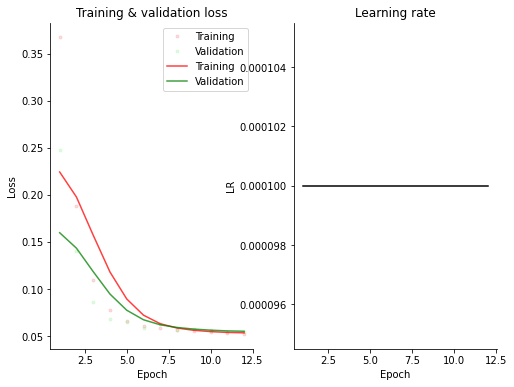

In [ ]:
#import trainer 
#imp.reload(trainer)
fig = tr.plot_training(training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=2,
    figsize=(8, 6))

## Saving Model and Reloading to check that F-1 scores are the same

In [ ]:
import pickle
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score





filename = '3_channels_2classes_b3_s32_a025_g2_91.sav'
#pickle.dump(model, open(filename, 'wb'))
 
preprocess = pr.preprocess
postprocess = pr.postprocess

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
 
import sys
sys.path.append(r'/content/drive/MyDrive/irp-ok121/Unet')
with open('/content/drive/MyDrive/irp-ok121/3_channels_2classes_b3_s32_a025_g2_91.sav', 'rb') as fs:
            loaded_model = pickle.load(fs)

# load the model from disk
#loaded_model = pickle.load(open('/content/drive/MyDrive/irp-ok121/Unet/10_channels_4classes_b3_s32_a025_g2_77.sav', 'rb'))
preds = np.array([Fri_unet.predict(img, loaded_model, preprocess, postprocess, device) for img in inputs_test])
ba = balanced_accuracy_score(targets_test.reshape( 178* 64*64), preds.reshape(178 * 64*64))
f1 =  f1_score(targets_test.reshape(178 * 64*64), preds.reshape(178 * 64*64), average= None)
print(ba, f1)    

0.7789556901639099 [0.8478288  0.61728193]


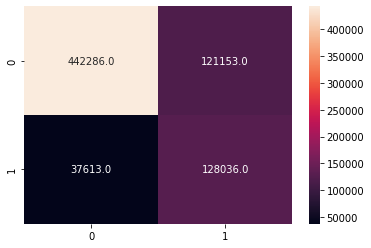

In [188]:
#Plotting confusion matrix to calculate comission and omission errors
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(targets_test.reshape(178*64*64), preds.reshape(178 *64*64))
sn.heatmap(cm, annot = True, fmt=".1f")

#Plotting the Results


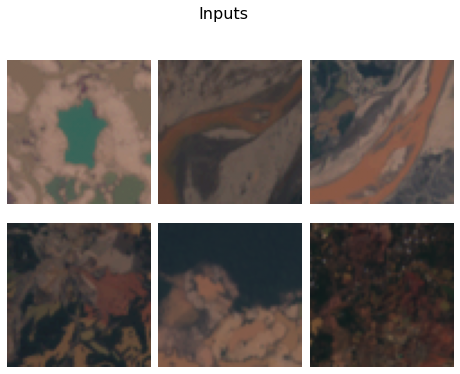

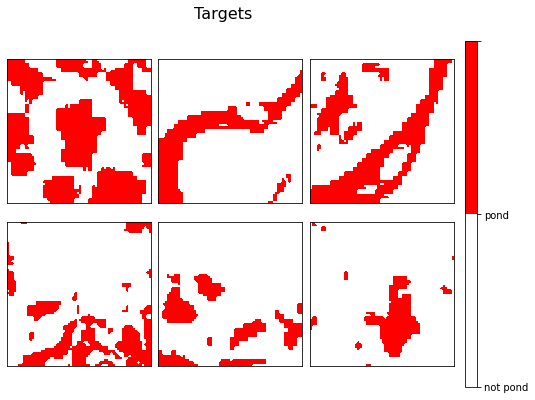

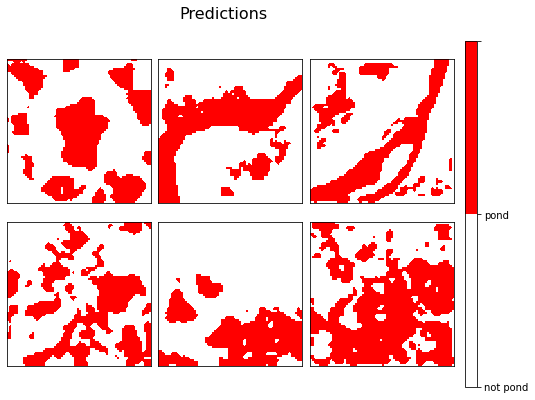

In [ ]:
from Tools import visualizer as viz
imp.reload(viz)
viz.visualise_results(inputs_test,  preds, 2, 13
                      , targets_test)




# Using Models on data from Ghana



In [ ]:
from Tools import ghana as gn
path = '/content/drive/MyDrive/irp-ok121/data/Ghana'
chanels = 10
ghana_images = gn.open_ghana_images(path, chanels )


In [ ]:
import pickle
from Unet import Fri_unet
sys.path.append(r'/content/drive/MyDrive/irp-ok121/Unet')
with open('/content/drive/MyDrive/irp-ok121/Unet/10_channels_4classes_b3_s32_a025_g2_77.sav', 'rb') as fs:
            loaded_model = pickle.load(fs)

ashanti_inputs, ashanti_preds, ferric_iron_ashanti = gn.ghana_analyser(ghana_images[0], input_path, 42, 10, loaded_model)
dawusaso_inputs, dawusaso_preds, ferric_iron_dawusaso = gn.ghana_analyser(ghana_images[1], input_path, 42, 10, loaded_model)
hun_inputs, hun_preds, ferric_iron_hun = gn.ghana_analyser(ghana_images[2], input_path, 42, 10, loaded_model)
nkwanta_inputs, nkwanta_preds, ferric_iron_nkwanta = gn.ghana_analyser(ghana_images[3], input_path, 42, 10, loaded_model)


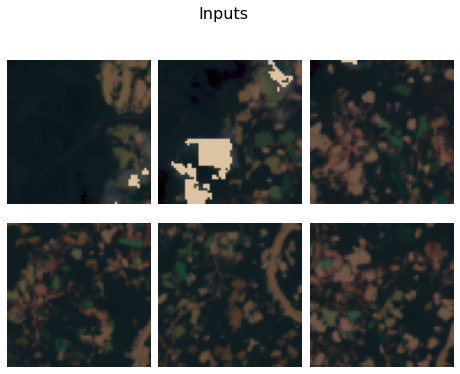

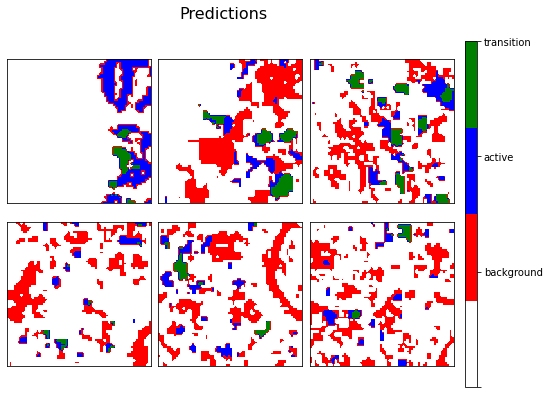

In [ ]:
from Tools import visualizer as viz
viz.visualise_results(hun_inputs, hun_preds, 4, 3)

# Discovering difrence of metals concentration per pond categories
# Application 1: Site comparison

In [ ]:
imp.reload(gn)

#Calculating proportions of ponds classes and
#ferric iron values within all ponds are extracted into one list

#transition_ashanti, transition_dawusaso,  transition_hun, transition_nkwanta,
active_ashanti, transition_ashanti, inactive_ashanti, iron_total_ashanti = gn.calculate_area( ashanti_preds, ferric_iron_ashanti)
active_dawusaso, transition_dawusaso,  inactive_dawusaso, iron_total_dawusaso = gn.calculate_area( dawusaso_preds, ferric_iron_dawusaso)
active_hun, transition_hun, inactive_hun, iron_total_hun = gn.calculate_area( hun_preds, ferric_iron_hun)
active_nkwanta, transition_nkwanta, inactive_nkwanta, iron_total_nkwanta = gn.calculate_area(nkwanta_preds, ferric_iron_nkwanta)


print(active_ashanti,   inactive_ashanti)
print(active_dawusaso, inactive_dawusaso)
print(active_hun,  inactive_hun)
print(active_nkwanta,  inactive_nkwanta)

0.8648819752193181 0.07180971330378945
0.6881773399014778 0.10403940886699507
0.7704757633821191 0.09739492029842227
0.7368027888446215 0.07889276228419655


In [ ]:
#Creating lists of minor ferric iron values per pond category
import itertools
#transition_iron_ashanti,  transition_iron_dawusaso, transition_iron_hun, transition_iron_nkwanta,

active_iron_ashanti, transition_iron_ashanti,  inactive_iron_ashanti,  non_pond_iron_ashanti = gn.extract_iron_values_per_category(ashanti_preds, ferric_iron_ashanti)
active_iron_dawusaso, transition_iron_dawusaso, inactive_iron_dawusaso,  non_pond_iron_dawusaso = gn.extract_iron_values_per_category(dawusaso_preds, ferric_iron_dawusaso)

active_iron_hun, transition_iron_hun,  inactive_iron_hun,  non_pond_iron_hun = gn.extract_iron_values_per_category(hun_preds, ferric_iron_hun)
active_iron_nkwanta,  transition_iron_nkwanta, inactive_iron_nkwanta,  non_pond_iron_nkwanta = gn.extract_iron_values_per_category(nkwanta_preds, ferric_iron_nkwanta)

active_total = list(itertools.chain(active_iron_ashanti, active_iron_dawusaso, active_iron_hun, active_iron_nkwanta))
inactive_total = list(itertools.chain(inactive_iron_ashanti, inactive_iron_dawusaso, inactive_iron_hun, inactive_iron_nkwanta))
transition_total = list(itertools.chain(transition_iron_ashanti, transition_iron_dawusaso, transition_iron_hun, transition_iron_nkwanta))
non_pond_total = list(itertools.chain(non_pond_iron_ashanti, non_pond_iron_dawusaso,  non_pond_iron_hun, non_pond_iron_nkwanta))

Text(0, 0.5, 'Probability Dencity')

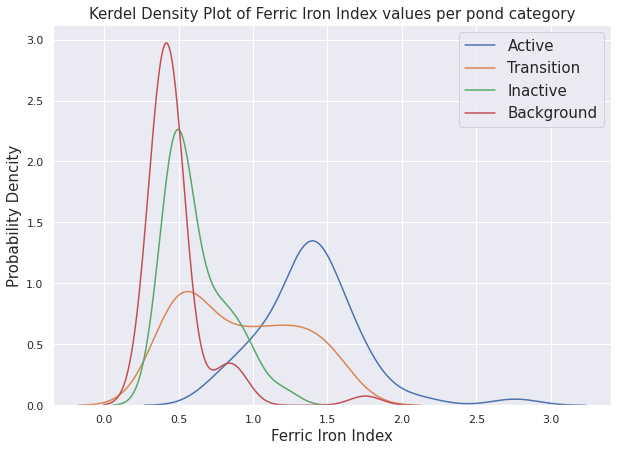

In [ ]:
import random 
import seaborn as sns
from scipy import stats

active_sample = random.sample(active_total, 50)
inactive_sample = random.sample(inactive_total, 50)
transition_sample = random.sample(transition_total, 50)
other_sample = random.sample(non_pond_total, 50)

p_value = format(stats.kruskal( inactive_sample, active_sample, other_sample)[1], '.3g')
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,7)})
sns.kdeplot(np.array(active_sample), label = 'Active')
sns.kdeplot(np.array(transition_sample), label = 'Transition')
sns.kdeplot(np.array(inactive_sample), label = 'Inactive')
sns.kdeplot(np.array(other_sample), label = 'Background')
plt.legend( fontsize = 15)
plt.title('Kerdel Density Plot of Ferric Iron Index values per pond category', fontsize = 15)

#plt.text(1.3, 1.9, """Distributions of Minor Ferric Iron index
#is Statistically significant.
#The p-value from Kruskal-Walis test is """ + p_value, 
#         horizontalalignment='left', size='small', color='black', fontsize = 13)
plt.xlabel("Ferric Iron Index", fontsize = 15)
plt.ylabel("Probability Dencity", fontsize = 15)

In [ ]:
#Checking if difference in Ferric Iron within inactive ponds 
#and other land class if significant
format(stats.kruskal(inactive_sample, other_sample)[1], '.3g')

'0.000101'

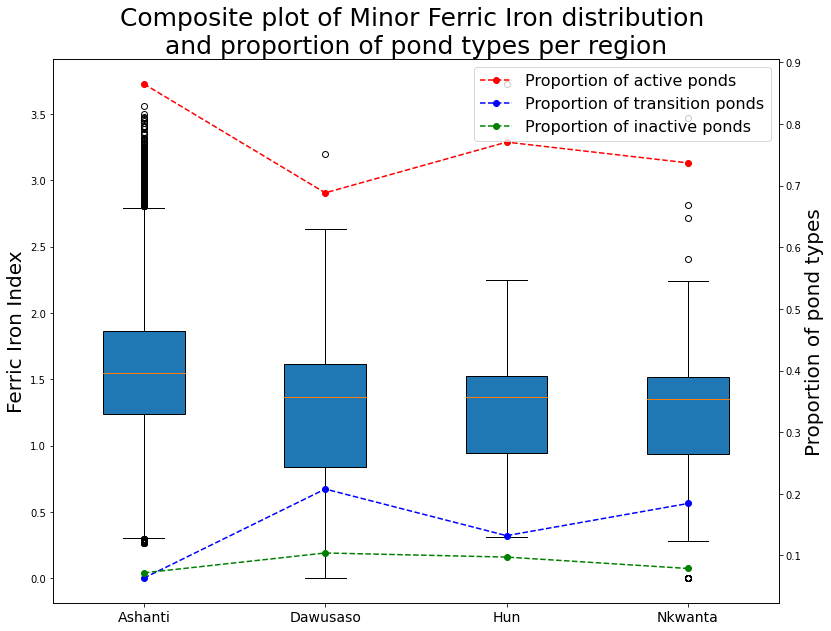

In [ ]:
iron_total_nkwanta = [x for x in iron_total_nkwanta if np.isnan(x) == False]
iron_total_dawusaso = [x for x in iron_total_dawusaso if np.isnan(x) == False]
iron_total_hun = [x for x in iron_total_hun if np.isnan(x) == False]

sns.reset_orig()
ferric_iron = [iron_total_ashanti, iron_total_dawusaso, iron_total_hun, iron_total_nkwanta]
fig, ax = plt.subplots(figsize = (13, 10))

ax.boxplot(ferric_iron, patch_artist = True)
ax.set_xticklabels(['Ashanti', 'Dawusaso', 'Hun', "Nkwanta"], fontsize = 14)
# Get box-plot x-tick locations
locs=ax.get_xticks()
ax2 = ax.twinx()

ax2.plot(locs, [active_ashanti, active_dawusaso, active_hun, active_nkwanta], '--bo', color = 'red',
         label = 'Proportion of active ponds')
ax2.plot(locs, [transition_ashanti, transition_dawusaso, transition_hun, transition_nkwanta], '--bo', color = 'blue', 
         label = 'Proportion of transition ponds')
ax2.plot(locs, [inactive_ashanti, inactive_dawusaso, inactive_hun, inactive_nkwanta], '--bo', color = 'green', 
         label = 'Proportion of inactive ponds')

ax2.legend(fontsize = 16)

plt.title("""Composite plot of Minor Ferric Iron distribution 
and proportion of pond types per region""", fontsize = 25)

plt.xlabel("Region", fontsize = 15)
ax.set_ylabel("Ferric Iron Index", fontsize = 20)
ax2.set_ylabel("Proportion of pond types", fontsize = 20)

plt.savefig('Ghana Region Comparison.png')


# Application 2: Exploring Seasonal Cycles of gold mining in Ghana using Planet basemaps

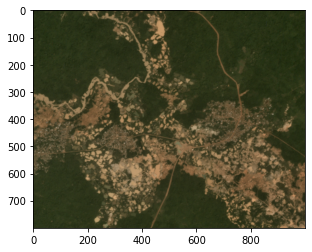

In [ ]:
imp.reload(gn)

#Loading monthly composites and cutting the small area for faster processsing

jan_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/January_2020.tif'
feb_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/February_2020.tif'
mar_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/March_2020.tif'
apr_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/April_2020.tif'
may_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/May_2020.tif'
jun_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/June_2020.tif'
aug_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/August_2020.tif'
oct_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/October_2020_new.tif'
nov_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/November_2020.tif'
dec_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Seasonal Cycle/December_2020.tif'

jan = pr.open_tiff_file(jan_path)[2500:3300, 1500:2500, :3]
feb = pr.open_tiff_file(feb_path)[2500:3300, 1500:2500, :3]
mar = pr.open_tiff_file(mar_path)[2500:3300, 1500:2500, :3]
apr = pr.open_tiff_file(apr_path)[2500:3300, 1500:2500, :3]
may = pr.open_tiff_file(may_path)[2500:3300, 1500:2500, :3]
jun = pr.open_tiff_file(jun_path)[2500:3300, 1500:2500, :3]
aug = pr.open_tiff_file(aug_path)[2500:3300, 1500:2500, :3]
oct = pr.open_tiff_file(oct_path)[2500:3300, 1500:2500, :3]
nov = pr.open_tiff_file(nov_path)[2500:3300, 1500:2500, :3]
dec = pr.open_tiff_file(dec_path)[2500:3300, 1500:2500, :3]

plt.imshow(dec[:, :, :3].astype(np.uint8))

In [ ]:
import pickle
from Unet import Fri_unet
sys.path.append(r'/content/drive/MyDrive/irp-ok121/Unet')
with open('/content/drive/MyDrive/irp-ok121/Unet/3_channels_4_classes_b3_s32_a025_g5_62.sav', 'rb') as fs:
            loaded_model = pickle.load(fs)

jan_inputs, jan_preds, ferric_iron_jan = gn.ghana_analyser(jan, input_path, 42, 3, loaded_model)
feb_inputs, feb_preds, ferric_iron_feb = gn.ghana_analyser(feb, input_path, 42, 3, loaded_model)
mar_inputs, mar_preds, ferric_iron_mar = gn.ghana_analyser(mar, input_path, 42, 3, loaded_model)
apr_inputs, apr_preds, ferric_iron_apr = gn.ghana_analyser(apr, input_path, 42, 3, loaded_model)
may_inputs, may_preds, ferric_iron_may = gn.ghana_analyser(may, input_path, 42, 3, loaded_model)
jun_inputs, jun_preds, ferric_iron_jun = gn.ghana_analyser(jun, input_path, 42, 3, loaded_model)
aug_inputs, aug_preds, ferric_iron_aug = gn.ghana_analyser(aug, input_path, 42, 3, loaded_model)
oct_inputs, oct_preds, ferric_iron_oct = gn.ghana_analyser(oct, input_path, 42, 3, loaded_model)
nov_inputs, nov_preds, ferric_iron_nov = gn.ghana_analyser(nov, input_path, 42, 3, loaded_model)
dec_inputs, dec_preds, ferric_iron_dec = gn.ghana_analyser(dec, input_path, 42, 3, loaded_model)


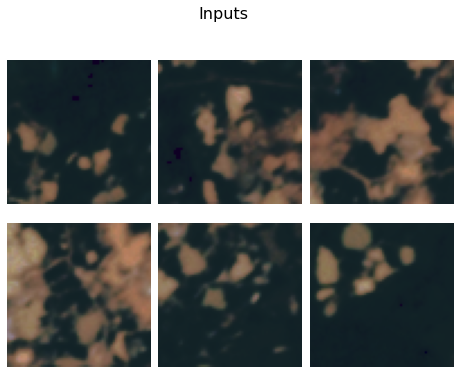

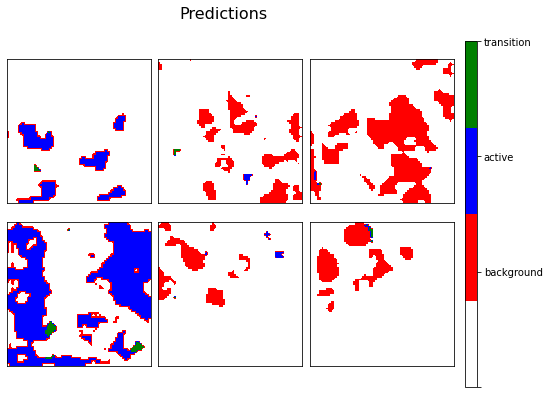

In [ ]:

viz.visualise_results(dec_inputs,  dec_preds, 4, 13)

In [ ]:
active_jan, transition_jan,  inactive_jan, iron_total_jan = gn.calculate_area(jan_preds, ferric_iron_jan)
active_feb, transition_feb, inactive_feb, iron_total_feb = gn.calculate_area(feb_preds, ferric_iron_feb)
active_mar, transition_mar, inactive_mar, iron_total_mar = gn.calculate_area(mar_preds, ferric_iron_mar)
active_apr, transition_apr, inactive_apr, iron_total_apr = gn.calculate_area(apr_preds, ferric_iron_apr)
active_may, transition_may, inactive_may, iron_total_may = gn.calculate_area(may_preds, ferric_iron_may)
active_jun, transition_jun, inactive_jun, iron_total_jun = gn.calculate_area(jun_preds, ferric_iron_jun)
active_aug, transition_aug, inactive_aug, iron_total_aug = gn.calculate_area(aug_preds, ferric_iron_aug)
active_oct, transition_oct, inactive_oct, iron_total_oct = gn.calculate_area(oct_preds, ferric_iron_oct)
active_nov, transition_nov, inactive_nov, iron_total_nov = gn.calculate_area(nov_preds, ferric_iron_nov)
active_dec, transition_dec, inactive_dec, iron_total_dec = gn.calculate_area(dec_preds, ferric_iron_dec)

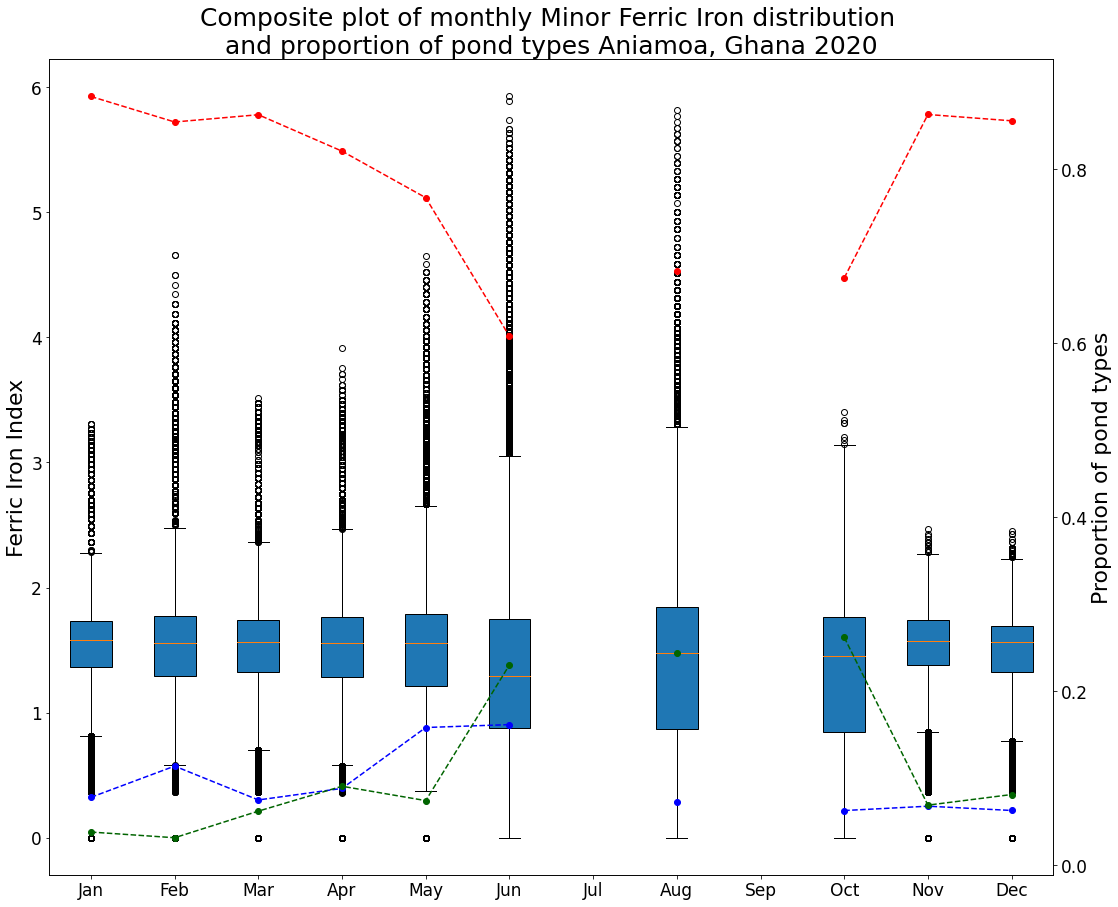

In [ ]:
iron_total_jan = [x for x in iron_total_jan if np.isnan(x) == False]
iron_total_feb = [x for x in iron_total_feb if np.isnan(x) == False]
iron_total_mar = [x for x in iron_total_mar if np.isnan(x) == False]

iron_total_apr = [x for x in iron_total_apr if np.isnan(x) == False]
iron_total_may = [x for x in iron_total_may if np.isnan(x) == False]
iron_total_jun = [x for x in iron_total_jun if np.isnan(x) == False]

iron_total_aug = [x for x in iron_total_aug if np.isnan(x) == False]
iron_total_oct = [x for x in iron_total_oct if np.isnan(x) == False]
iron_total_nov = [x for x in iron_total_nov if np.isnan(x) == False]
iron_total_dec = [x for x in iron_total_dec if np.isnan(x) == False]

iron_total_jul = []
iron_total_sep = []

#sns.reset_orig()
ferric_iron = [iron_total_jan, iron_total_feb,  iron_total_mar, iron_total_apr,
               iron_total_may, iron_total_jun, iron_total_jul, iron_total_aug, 
               iron_total_sep, iron_total_oct, iron_total_nov, iron_total_dec]
fig, ax = plt.subplots(figsize = (18, 15))

ax.boxplot(ferric_iron, patch_artist = True)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 14)
# Get box-plot x-tick locations
locs=ax.get_xticks()
ax2 = ax.twinx()



ax2.plot(locs, [active_jan, active_feb, active_mar, active_apr, 
                active_may, active_jun, None, active_aug, None, active_oct, active_nov, active_dec], '--bo', color = 'red',
                label = 'Proportion of active ponds')
ax2.plot(locs, [transition_jan, transition_feb, transition_mar, transition_apr,
                transition_may, transition_jun, None, transition_aug, None, transition_oct, transition_nov, transition_dec], '--bo', color = 'blue', 
         label = 'Proportion of transition ponds')
ax2.plot(locs, [inactive_jan, inactive_feb, inactive_mar, inactive_apr, 
                inactive_may, inactive_jun, None, inactive_aug, None,  inactive_oct, inactive_nov, inactive_dec], '--bo', color = 'darkgreen', 
                label = 'Proportion of inactive ponds')

#ax2.legend(fontsize = 15, loc = 0, bbox_to_anchor=(0.6, 0.3, 0.7145, 0.5))

plt.title("""Composite plot of monthly Minor Ferric Iron distribution 
and proportion of pond types Aniamoa, Ghana 2020""", fontsize = 25)

ax.set_ylabel("Ferric Iron Index", fontsize = 22)
ax2.set_ylabel("Proportion of pond types", fontsize = 22)
ax.tick_params(labelsize = 17)
ax2.tick_params(labelsize = 17)
plt.savefig('Seasonal cycle.png')

#application 3: Computing Timeline 2018 - 2022

In [ ]:
Q1_2018_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Timeline/2018.tif'
Q1_2019_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Timeline/2019.tif'
Q1_2020_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Timeline/2020.tif'
Q1_2021_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Timeline/2021.tif'
Q1_2022_path = '/content/drive/MyDrive/irp-ok121/data/Ghana/Planet_data/Timeline/2022.tif'

In [ ]:
Q1_2018 = pr.open_tiff_file(Q1_2018_path)[2500:3300, 1500:2500, :3]
Q1_2019 = pr.open_tiff_file(Q1_2019_path)[2500:3300, 1500:2500, :3]
Q1_2020 = pr.open_tiff_file(Q1_2020_path)[2500:3300, 1500:2500, :3]
Q1_2021 = pr.open_tiff_file(Q1_2021_path)[2500:3300, 1500:2500, :3]
Q1_2022 = pr.open_tiff_file(Q1_2022_path)[2500:3300, 1500:2500, :3]

In [ ]:
Q1_2018_inputs, Q1_2018_preds, ferric_iron_Q1_2018 = gn.ghana_analyser(Q1_2018, input_path, 42, 3, loaded_model)
Q1_2019_inputs, Q1_2019_preds, ferric_iron_Q1_2019 = gn.ghana_analyser(Q1_2019, input_path, 42, 3, loaded_model)
Q1_2020_inputs, Q1_2020_preds, ferric_iron_Q1_2020 = gn.ghana_analyser(Q1_2020, input_path, 42, 3, loaded_model)
Q1_2021_inputs, Q1_2021_preds, ferric_iron_Q1_2021 = gn.ghana_analyser(Q1_2021, input_path, 42, 3, loaded_model)
Q1_2022_inputs, Q1_2022_preds, ferric_iron_Q1_2022 = gn.ghana_analyser(Q1_2022, input_path, 42, 3, loaded_model)


In [ ]:
active_Q1_2018, transition_Q1_2018,  inactive_Q1_2018, iron_total_Q1_2018 = gn.calculate_area(Q1_2018_preds, ferric_iron_Q1_2018)
active_Q1_2019, transition_Q1_2019, inactive_Q1_2019, iron_total_Q1_2019 = gn.calculate_area(Q1_2019_preds, ferric_iron_Q1_2019)
active_Q1_2020, transition_Q1_2020, inactive_Q1_2020, iron_total_Q1_2020 = gn.calculate_area(Q1_2020_preds, ferric_iron_Q1_2020)
active_Q1_2021, transition_Q1_2021, inactive_Q1_2021, iron_total_Q1_2021 = gn.calculate_area(Q1_2021_preds, ferric_iron_Q1_2021)
active_Q1_2022, transition_Q1_2022, inactive_Q1_2022, iron_total_Q1_2022 = gn.calculate_area(Q1_2022_preds, ferric_iron_Q1_2022)


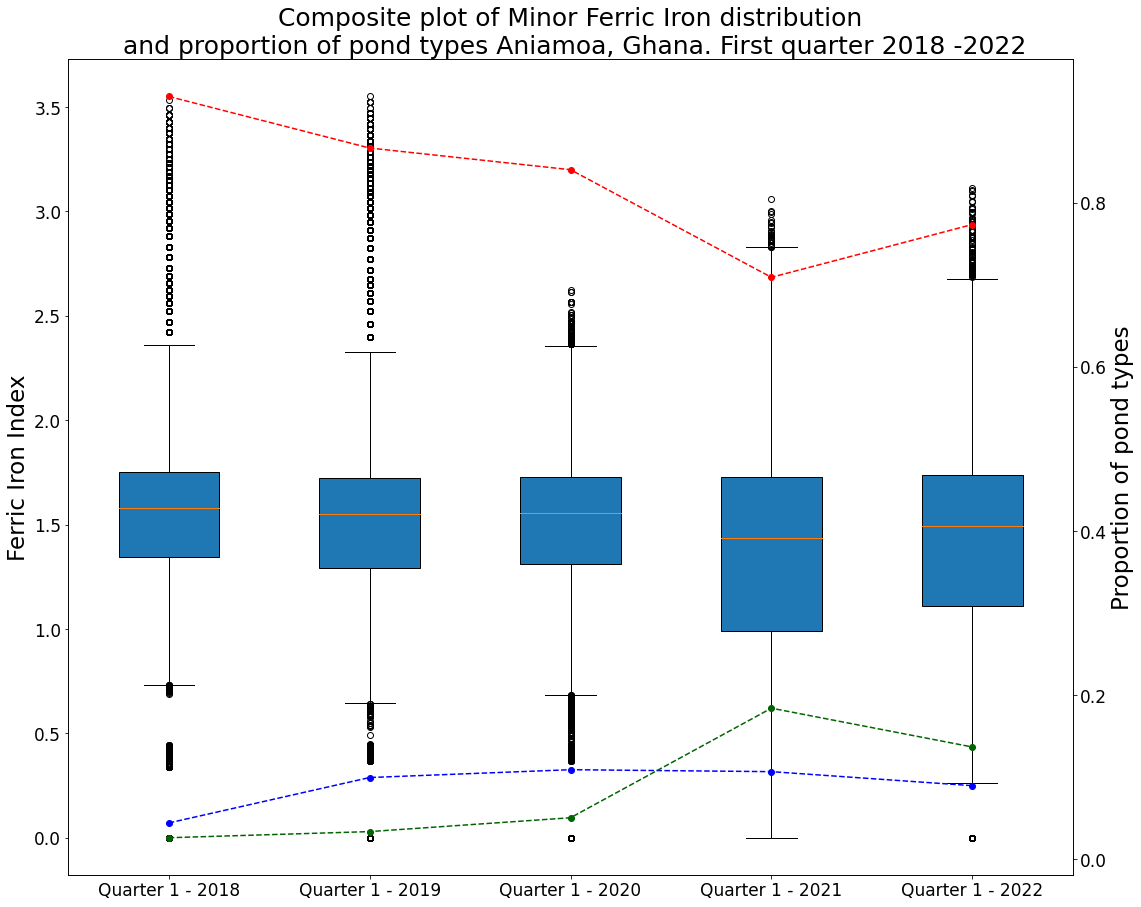

In [ ]:
iron_total_Q1_2018 = [x for x in iron_total_Q1_2018 if np.isnan(x) == False]
iron_total_Q1_2019 = [x for x in iron_total_Q1_2019 if np.isnan(x) == False]
iron_total_Q1_2020 = [x for x in iron_total_Q1_2020 if np.isnan(x) == False]

iron_total_Q1_2021 = [x for x in iron_total_Q1_2021 if np.isnan(x) == False]
iron_total_Q1_2022 = [x for x in iron_total_Q1_2022 if np.isnan(x) == False]

ferric_iron = [iron_total_Q1_2018, iron_total_Q1_2019, iron_total_Q1_2020, 
               iron_total_Q1_2021, iron_total_Q1_2022]
fig, ax = plt.subplots(figsize = (18, 15))

ax.boxplot(ferric_iron, patch_artist = True)
ax.set_xticklabels(['Quarter 1 - 2018', 'Quarter 1 - 2019', 'Quarter 1 - 2020', 
                    'Quarter 1 - 2021', 'Quarter 1 - 2022'], fontsize = 14)
# Get box-plot x-tick locations
locs=ax.get_xticks()
ax2 = ax.twinx()



ax2.plot(locs, [active_Q1_2018, active_Q1_2019, active_Q1_2020, 
                active_Q1_2021, active_Q1_2022], '--bo', color = 'red',
                label = 'Proportion of active ponds')
ax2.plot(locs, [transition_Q1_2018, transition_Q1_2019, transition_Q1_2020,
                transition_Q1_2021, transition_Q1_2022], '--bo', color = 'blue', 
         label = 'Proportion of transition ponds')
ax2.plot(locs, [inactive_Q1_2018, inactive_Q1_2019, inactive_Q1_2020, 
                inactive_Q1_2021, inactive_Q1_2022], '--bo', color = 'darkgreen', 
                label = 'Proportion of inactive ponds')

#ax2.legend(fontsize = 15, loc = 0, bbox_to_anchor=(0.6, 0.3, 0.7145, 0.5))

plt.title("""Composite plot of Minor Ferric Iron distribution
 and proportion of pond types Aniamoa, Ghana. First quarter 2018 -2022""", fontsize = 25)

ax.set_ylabel("Ferric Iron Index", fontsize = 23)
ax2.set_ylabel("Proportion of pond types", fontsize = 23)
ax.tick_params(labelsize = 17)
ax2.tick_params(labelsize = 17)
plt.savefig('Quarterly timeline.png')